In [ ]:
# Kaggle Dog Breed Image Classification Dataset - Kaggle Dog Breed Image 은 개 품종 예측 이미지 분류

# Kaggle Breast Ultrasound MRI 은 유방 초음파 예측 이미지 분류
# Bedlington_terrier - 136 files
# Bernese_mountain_dog - 131 files
# Dandie_Dinmont - 115 files
# Gordon_setter - 116 files
# Ibizan_hound - 124 files
# Norwegian_elkhound - 
# 발견하고 예측하기 위해서 Kaggle의 공개 데이터로서 총 622개 개 품종 이미지 데이터

# MobileNet(pre-trained model) -> GlobalAveragePooling(Flatten Layer) -> Linear -> ReLU -> Dropout -> Linear -> ReLU -> softmax
# Transfer Learning 사용함 - pre-trained model(mobilenet_v2)

In [1]:
# 라이브러리
import os, shutil, zipfile, random, glob
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split

# GPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [15]:
# ===============================
# 데이터 경로 설정
# ===============================
ROOT_DIR = '.\\data'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'dog_breed_image\\data')
CLASSIFICATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Classification')
CLASSIFICATION_TRAIN_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'Train')
CLASSIFICATION_TEST_DATA_ROOT_DIR = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'Test')

In [9]:
# 데이터 폴더 존재시 삭제
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    print(DATA_ROOT_DIR + ' is removed')

if os.path.exists(CLASSIFICATION_DATA_ROOT_DIR):
    shutil.rmtree(CLASSIFICATION_DATA_ROOT_DIR)
    print(CLASSIFICATION_DATA_ROOT_DIR + ' is removed')

.\data\dog_breed_image is removed


In [10]:
# 압축 해제
with zipfile.ZipFile(os.path.join(ROOT_DIR, 'dog_breed_image.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [16]:
# 데이터 전처리 - 원본데이터 -> train 데이터 구축

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, '*'))
print(total_file_list)

# list comprehension 이용해서 normal(정상), benign(양성), malignant(악성) 등의 정답 리스트 생성
label_name_list = [ file_name.split('\\')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name) == True ]
print(label_name_list)

if not os.path.exists(CLASSIFICATION_DATA_ROOT_DIR): # 원본 데이터와 동일한 정답을 가지는 Classification 디렉토리 생성
    os.mkdir(CLASSIFICATION_DATA_ROOT_DIR)

for label_name in label_name_list: # 각각의 정답(label)
    src_dir_path = os.path.join(DATA_ROOT_DIR, label_name) # 원본 이미지 경로
    dst_dir_path = os.path.join(CLASSIFICATION_DATA_ROOT_DIR, 'train'+'\\'+label_name) # 복사될 이미지 경로

    try:
        shutil.copytree(src_dir_path, dst_dir_path) # shutil.copytree 이용해서 원본 데이터와 동일한 정답을 가지는 train 디렉토리 생성 및 이미지 복사
    except Exception as err:
        print(str(err))

train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)
for label_name in train_label_name_list:
    print('train label : ', label_name, ' => ', len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name))))

['.\\data\\dog_breed_image\\data\\Bedlington_terrier', '.\\data\\dog_breed_image\\data\\Bernese_mountain_dog', '.\\data\\dog_breed_image\\data\\Dandie_Dinmont', '.\\data\\dog_breed_image\\data\\Gordon_setter', '.\\data\\dog_breed_image\\data\\Ibizan_hound', '.\\data\\dog_breed_image\\data\\Norwegian_elkhound']
['Bedlington_terrier', 'Bernese_mountain_dog', 'Dandie_Dinmont', 'Gordon_setter', 'Ibizan_hound', 'Norwegian_elkhound']
train label :  Bedlington_terrier  =>  136
train label :  Bernese_mountain_dog  =>  131
train label :  Dandie_Dinmont  =>  115
train label :  Gordon_setter  =>  116
train label :  Ibizan_hound  =>  124
train label :  Norwegian_elkhound  =>  130


In [7]:
# 데이터 전처리 - Classification 을 위해서는 불필요한 mask 이미지 파일 제거
# train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)
# print(train_label_name_list)

# for label_name in train_label_name_list: # train 디렉토리의 각각 정답(label)
#     temp_dic = {}
#     file_list = glob.glob(CLASSIFICATION_TRAIN_DATA_ROOT_DIR + '\\' + label_name + '\\*') # 정답(label) 디렉토리에 있는 이미지 파일 목록을 추출
#     print(file_list)
#     temp_dic[label_name] = file_list

#     temp_df = pd.DataFrame(temp_dic) # 파일리스트를 column으로 가지는 임시적인 temp_df 데이터프레임 생성
#     image_file_df = temp_df[~temp_df[label_name].str.contains('_mask')].reset_index(drop=True) # 파일 이름에 _mask 를 포함하지 않는 파일 목록, Classification에서 사용되는 이미지 파일 목록
#     mask_file_df = temp_df[temp_df[label_name].str.contains('_mask')].reset_index(drop=True) # 파일 이름에 _mask 를 포함하는 파일 목록, Segmentation에서 사용되는 이미지 파일 목록
#     print('label = ', label_name, ' , image = ', len(image_file_df), ' , mask = ', len(mask_file_df))

#     for row in range(len(mask_file_df)):
#         try:
#             os.remove(mask_file_df.loc[row, label_name])
#         except Exception as err:
#             print(str(err))

In [17]:
# 데이터 전처리 - train 데이터 -> test 데이터 구축

MOVE_RATIO = 0.2 # train : test = 80 : 20, train 데이터 20% 데이터를 test 데이터로 사용

label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)
print(label_name_list)

if not os.path.exists(CLASSIFICATION_TEST_DATA_ROOT_DIR): # 원본 데이터와 동일한 정답을 가지는 Classification 디렉토리 생성
    os.mkdir(CLASSIFICATION_TEST_DATA_ROOT_DIR)

for label_name in label_name_list: # train 디렉토리의 각각 정답(label)
    if not os.path.exists(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name)): # 원본 데이터와 동일한 정답을 가지는 Classification 디렉토리 생성
        os.mkdir(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name))

    src_dir_path = os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name) # train 디렉토리의 정답(label) 경로
    dst_dir_path = os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name) # test 디렉토리의 정답(label) 경로

    print(src_dir_path, dst_dir_path)

    train_data_file_list = os.listdir(src_dir_path) # 정답(label) 디렉토리에 있는 이미지 파일 목록을 추출
    random.shuffle(train_data_file_list) # 데이터를 섞어줌

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num] # train 데이터의 20%를 test 데이터로 사용
    print(len(test_data_file_list))

    for test_data_file in test_data_file_list:
        try: # train 데이터의 20%를 test 데이터로 이동
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

['Bedlington_terrier', 'Bernese_mountain_dog', 'Dandie_Dinmont', 'Gordon_setter', 'Ibizan_hound', 'Norwegian_elkhound']
.\data\dog_breed_image\data\Classification\Train\Bedlington_terrier .\data\dog_breed_image\data\Classification\Test\Bedlington_terrier
27
.\data\dog_breed_image\data\Classification\Train\Bernese_mountain_dog .\data\dog_breed_image\data\Classification\Test\Bernese_mountain_dog
26
.\data\dog_breed_image\data\Classification\Train\Dandie_Dinmont .\data\dog_breed_image\data\Classification\Test\Dandie_Dinmont
23
.\data\dog_breed_image\data\Classification\Train\Gordon_setter .\data\dog_breed_image\data\Classification\Test\Gordon_setter
23
.\data\dog_breed_image\data\Classification\Train\Ibizan_hound .\data\dog_breed_image\data\Classification\Test\Ibizan_hound
24
.\data\dog_breed_image\data\Classification\Train\Norwegian_elkhound .\data\dog_breed_image\data\Classification\Test\Norwegian_elkhound
26


In [18]:
# 데이터 전처리 - 최종 학습데이터 개수 확인

# train
train_label_name_list = os.listdir(CLASSIFICATION_TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

total_train_image_data_nums = 0

for label_name in train_label_name_list:
    train_image_data_nums = len(os.listdir(os.path.join(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, label_name)))
    print('label = ', label_name, ' , data nums = ', train_image_data_nums)
    total_train_image_data_nums += train_image_data_nums
print('total train image data nums = ', total_train_image_data_nums)

print('============================================================================')

# test
test_label_name_list = os.listdir(CLASSIFICATION_TEST_DATA_ROOT_DIR)
print(test_label_name_list)

total_test_image_data_nums = 0

for label_name in test_label_name_list:
    test_image_data_nums = len(os.listdir(os.path.join(CLASSIFICATION_TEST_DATA_ROOT_DIR, label_name)))
    print('label = ', label_name, ' , data nums = ', test_image_data_nums)
    total_test_image_data_nums += test_image_data_nums
print('total test image data nums = ', total_test_image_data_nums)

['Bedlington_terrier', 'Bernese_mountain_dog', 'Dandie_Dinmont', 'Gordon_setter', 'Ibizan_hound', 'Norwegian_elkhound']
label =  Bedlington_terrier  , data nums =  109
label =  Bernese_mountain_dog  , data nums =  105
label =  Dandie_Dinmont  , data nums =  92
label =  Gordon_setter  , data nums =  93
label =  Ibizan_hound  , data nums =  100
label =  Norwegian_elkhound  , data nums =  104
total train image data nums =  603
['Bedlington_terrier', 'Bernese_mountain_dog', 'Dandie_Dinmont', 'Gordon_setter', 'Ibizan_hound', 'Norwegian_elkhound']
label =  Bedlington_terrier  , data nums =  27
label =  Bernese_mountain_dog  , data nums =  26
label =  Dandie_Dinmont  , data nums =  23
label =  Gordon_setter  , data nums =  23
label =  Ibizan_hound  , data nums =  24
label =  Norwegian_elkhound  , data nums =  26
total test image data nums =  149


In [19]:
# ===============================
# Dataset 준비
# ===============================
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# transforms 설정
train_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# datasets.ImageFolder
train_dataset = datasets.ImageFolder(CLASSIFICATION_TRAIN_DATA_ROOT_DIR, transform=train_transforms)
test_dataset = datasets.ImageFolder(CLASSIFICATION_TEST_DATA_ROOT_DIR, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 정답 label
class_names = train_dataset.classes
print('클래스 : ', class_names)

클래스 :  ['Bedlington_terrier', 'Bernese_mountain_dog', 'Dandie_Dinmont', 'Gordon_setter', 'Ibizan_hound', 'Norwegian_elkhound']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].
Clipping input d

torch.Size([32, 3, 224, 224]) torch.Size([32])
{0: 'Bedlington_terrier', 1: 'Bernese_mountain_dog', 2: 'Dandie_Dinmont', 3: 'Gordon_setter', 4: 'Ibizan_hound', 5: 'Norwegian_elkhound'}


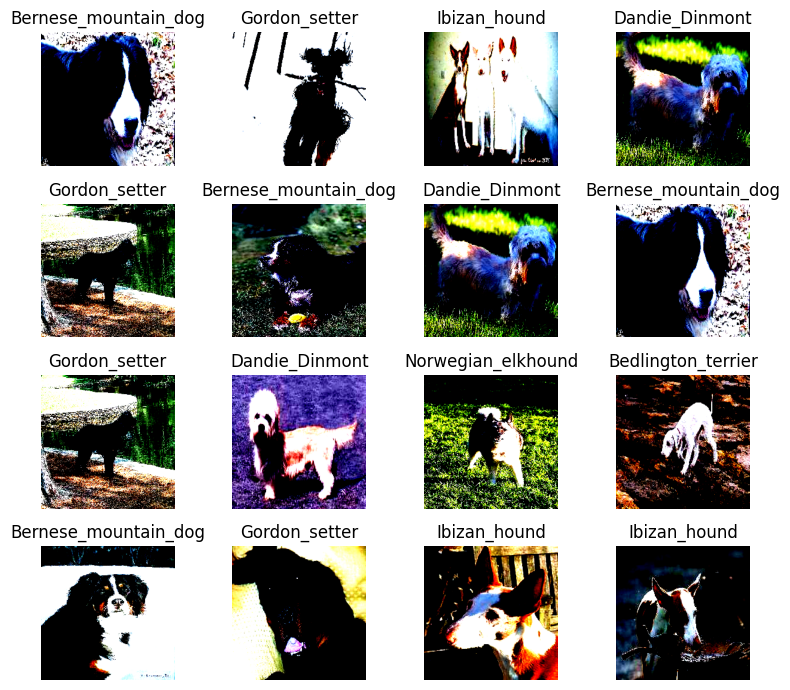

In [20]:
# 1개 배치 추출
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# labels map 생성
labels_map = { v : k for k, v in train_dataset.class_to_idx.items() }
print(labels_map)

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1, )).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    plt.subplot(rows, cols, i)
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드
print(model)
print('------------------------------')
print(model.last_channel)
print('------------------------------')
print(model.classifier[1].in_features)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [22]:
# ===============================
# 모델 정의 (MobileNetV2)
# ===============================
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # pre-trained model 다운로드

# nn.Sequential() 구조로 설계
# model.classifier = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(model.last_channel, 512), # 마지막 입력값(in_features=1280)을 가져오는 코드 - model.last_channel or model.classifier[1].in_features
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 128),
#     nn.ReLU(),
#     nn.Linear(128, len(class_names)),
#     nn.Softmax(dim=1)
# )

# MobileNet(pre-trained model) -> GlobalAveragePooling(Flatten Layer) -> Linear -> ReLU -> Dropout -> Linear -> ReLU -> softmax
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, 256), # 마지막 입력값(in_features=1280)을 가져오는 코드 - model.last_channel or model.classifier[1].in_features
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names)),
    nn.Softmax(dim=1)
)

In [23]:
# ======================
# 모델객체 & 손실함수 & 옵티마이저
# ======================
n_classes = len(class_names)
model = model.to(DEVICE)
print(model)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [24]:
# ===============================
# 학습 함수
# ===============================
def train_model(model, loss_function, optimizer, train_loader, val_loader, num_epochs, patience=5):
    best_loss = np.inf
    counter = 0
    train_acc_hist, val_acc_hist = [], []
    train_loss_hist, val_loss_hist = [], []

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # 미분 초기화
            outputs = model(inputs) # 모델 예측
            loss = loss_function(outputs, labels) # 손실함수 계산

            _, preds = torch.max(outputs, 1) # 예측값 분리
            loss.backward() # 미분 연산
            optimizer.step() # 미분 연산 후 파라미터(가중치, 바이어스) 업데이트

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset) # 평균 손실함수값
        epoch_acc = running_corrects.double() / len(train_loader.dataset) # 평균 정확도값
        train_loss_hist.append(epoch_loss)
        train_acc_hist.append(epoch_acc.item())

        # --- Validation ---
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad(): # 오차역전파 사용 안함, 미분 연산 하지 않음
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # 모델 예측
                loss = loss_function(outputs, labels) # 손실함수값 계산

                _, preds = torch.max(outputs, 1) # 예측값 분리
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset) # validation 평균 손실함수값
        val_acc = val_running_corrects.double() / len(val_loader.dataset) # validation 평균 정확도값
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc.item())

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f} "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(best_model_wts)
                break

    return model, (train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)

In [25]:
# ===============================
# 학습 실행
# ===============================
model, history = train_model(model, loss_function, optimizer, train_loader, test_loader, num_epochs=50)

Epoch 1/50 - Train loss: 1.7793, acc: 0.2405 Val loss: 1.7586, acc: 0.6376
Epoch 2/50 - Train loss: 1.7456, acc: 0.4428 Val loss: 1.7140, acc: 0.9060
Epoch 3/50 - Train loss: 1.6988, acc: 0.6949 Val loss: 1.6459, acc: 0.9597
Epoch 4/50 - Train loss: 1.6308, acc: 0.8308 Val loss: 1.5446, acc: 0.9933
Epoch 5/50 - Train loss: 1.5420, acc: 0.9022 Val loss: 1.4219, acc: 0.9933
Epoch 6/50 - Train loss: 1.4328, acc: 0.9569 Val loss: 1.3002, acc: 0.9933
Epoch 7/50 - Train loss: 1.3287, acc: 0.9635 Val loss: 1.2136, acc: 1.0000
Epoch 8/50 - Train loss: 1.2469, acc: 0.9900 Val loss: 1.1576, acc: 1.0000
Epoch 9/50 - Train loss: 1.1809, acc: 0.9967 Val loss: 1.1265, acc: 1.0000
Epoch 10/50 - Train loss: 1.1492, acc: 0.9900 Val loss: 1.1080, acc: 1.0000
Epoch 11/50 - Train loss: 1.1233, acc: 0.9934 Val loss: 1.0952, acc: 1.0000
Epoch 12/50 - Train loss: 1.1100, acc: 0.9983 Val loss: 1.0867, acc: 1.0000
Epoch 13/50 - Train loss: 1.0957, acc: 0.9967 Val loss: 1.0813, acc: 1.0000
Epoch 14/50 - Train l

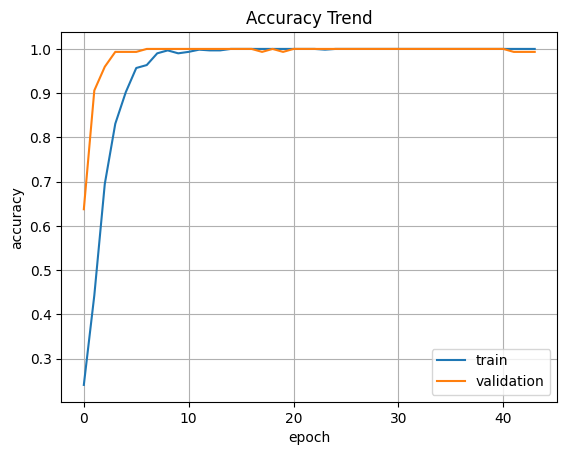

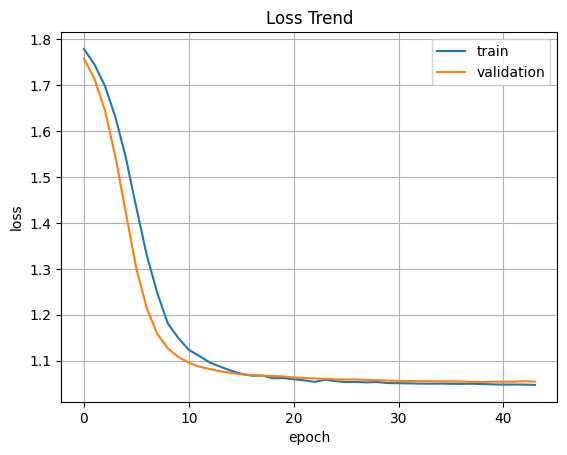

In [27]:
# ======================
# 정확도 및 손실 그래프
# ======================
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = history

plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='validation')
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_transfer_learning_dog_breed.ckpt')

In [29]:
# ===============================
# 테스트 성능 평가
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.33%
